# The model. Ref: Thomas Bauska

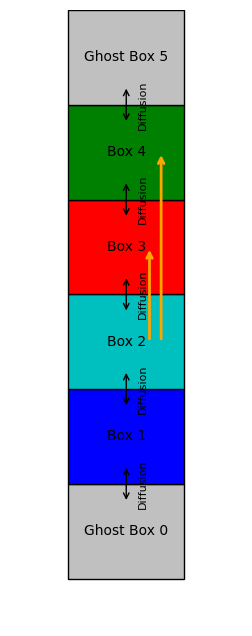

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a figure and axis
fig, ax = plt.subplots(figsize=(3, 8), dpi=100)

# Number of boxes including ghost boxes
num_boxes = 6  # Boxes from y=0 to y=5

color_list=['silver','b','c','r','g','silver']

# Draw rectangles for each grid cell
for y in range(num_boxes):
    if y == 0 or y == 5:
        # Ghost boxes (Neumann boundary conditions)
        rect = patches.Rectangle((0, y), 1, 1, linewidth=1, edgecolor='black', facecolor= color_list[y])
        ax.add_patch(rect)
        ax.text(0.5, y + 0.5, f'Ghost Box {y}', ha='center', va='center', fontsize=10)
    else:
        # Physical boxes
        rect = patches.Rectangle((0, y), 1, 1, linewidth=1, edgecolor='black', facecolor= color_list[y])
        ax.add_patch(rect)
        ax.text(0.5, y + 0.5, f'Box {y}', ha='center', va='center', fontsize=10)

# Draw diffusion arrows between adjacent boxes
for y in range(num_boxes - 1):
    # Draw bidirectional arrows (diffusion)
    ax.annotate(
        '', xy=(0.5, y + 0.8), xytext=(0.5, y + 1.2),
        arrowprops=dict(arrowstyle='<->', color='black', lw=1)
    )
    ax.text(0.6, y + 1, 'Diffusion', va='center', fontsize=8, rotation=90)


# Highlight the boxes involved in advection
advection_boxes = [2, 3, 4]  # Corresponding to y=2, y=3, y=4 in the code

# Draw advection arrows
# Advection removes from Box 2
# ax.annotate(
#     '', xy=(0.5, 2 + 0.1), xytext=(0.5, 2),
#     arrowprops=dict(arrowstyle='-|>', color='red', lw=2)
# )
# ax.text(0.6, 2 + 0.05, 'Advection Loss', va='center', fontsize=8, color='red')

# Advection adds to Box 3
# ax.annotate(
#     '', xy=(0.3, 3), xytext=(0.3, 2 + 0.9),
#     arrowprops=dict(arrowstyle='->', color='red', lw=2)
# )
# Advection adds to Box 4
ax.annotate(
    '', xy=(0.7, 3.5), xytext=(0.7, 2.5),
    arrowprops=dict(arrowstyle='->', color='orange', lw=2)
)

ax.annotate(
    '', xy=(0.8, 4.5), xytext=(0.8, 2.5),
    arrowprops=dict(arrowstyle='->', color='orange', lw=2)
)

ax.text(0.9, 3.5, 'Advection', va='center', fontsize=8, color='red', rotation=90)

# Set plot limits and remove axes
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, num_boxes)
ax.axis('off')

# Add title
# plt.title('Schematic of 1D Diffusion/Advection Model', fontsize=12)

# Display the plot
plt.show()


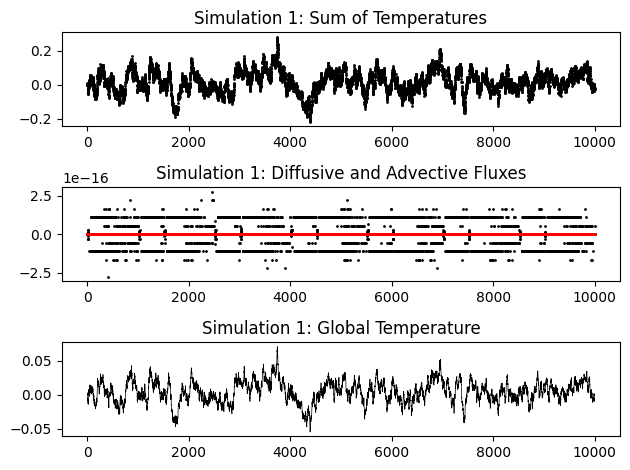

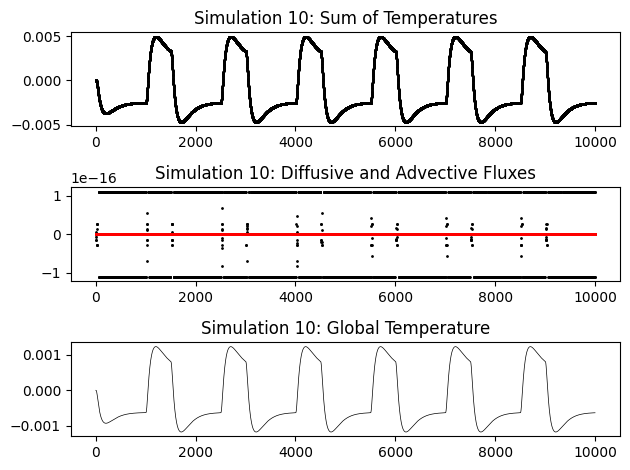

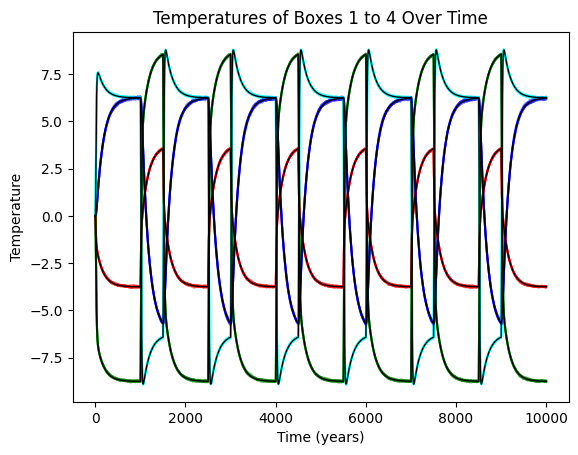

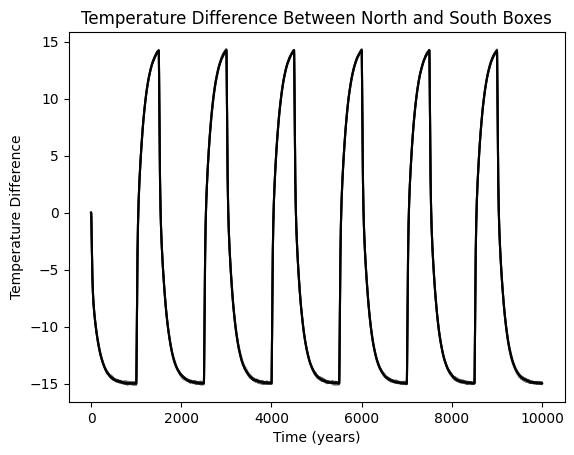

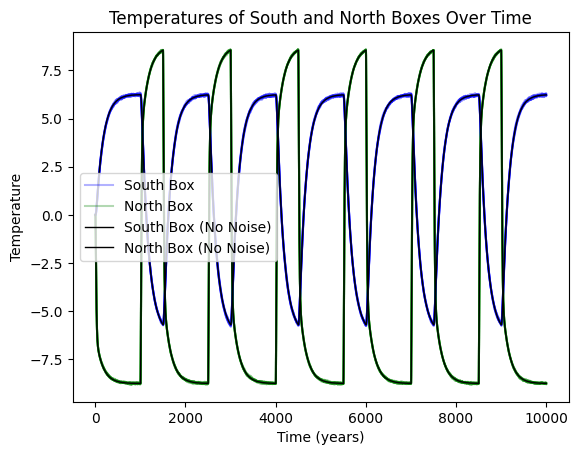

In [6]:
# ----------------------------------------------------------------------- #
#   Very rough draft of 1D diffusion/advection model for testing          #
#   Date: 14/10/2024            
#   Adapted from 2D diffusion/advection to there are some vestigial
#   features
#   Author: Thomas Bauska <thausk@bas.ac.uk>                              #
#                                                                         #
#=========================Basic Setup=====================================#
#-------------------------------------------------------------------------#

import numpy as np
import matplotlib.pyplot as plt

nx = 1     # core boxes akin to longitude (don't change!)
ny = 4     # core boxes akin to latitude (don't change!)

#--> NOTE: the boundary condition on the north and south (y) is a Neumann
# so there are a total of 6 boxes with boxes 1 and 6 forced to equal to boxes 
# 2 and 5, respectively. They are like ghost boxes such that derivative at the
# true boundary is zero.

# Boundary conditions on east and west (x) are wrapped around such that the grid is continuous

lengthx = 1  # domain length along x (unitless) (don't change!)
lengthy = 4  # domain length along y (unitless) don't change!)

dt = 1       # time step [nominally yr]  (there are some stability check below)
runlength = 10000  # length in years  <======CAN CHANGE 
nsteps = int(runlength / dt)  # number of timesteps (feel free to change)
bpss_reoccurence = 1000  # recurrence interval in years <======CAN CHANGE 
bpss_length = 500        # length of perturbation in years <======CAN CHANGE 

num_simulations = 10  # Total number of simulations

# Initialize arrays to save Temp, F, and Fadv for all loops
Temps = np.zeros((num_simulations, nx, ny + 2, nsteps))
Fs = np.zeros((num_simulations, nx, ny + 2, nsteps))
Fadvs = np.zeros((num_simulations, nx, ny + 2, nsteps))
global_temp_arrs = np.zeros((num_simulations, nsteps))
area_temp_arrs = np.zeros((num_simulations, nsteps))

for i in range(1, num_simulations + 1):  # this is a little loop which runs 9 simulations with noise and the last one without.

    # ===============Switches, Knobs and Tunable Parameters=====================#
    # -------------------------------------------------------------------------#
    # --Diffusion--#
    # Dy_var = [0.0005, 0.0005, 0.1, 0.1, 0.1]  # Variable diffusive parameter along y  <======CAN CHANGE 
    Dy_var = [0.005, 0.005, 0.1, 0.1, 0.1]  # Variable diffusive parameter along y  <======CAN CHANGE 
    # wy = 5  # advective flux (currently defunct)
    maxD = 0.1  # some relict code to check numerical stability. Here you can enter maximum diffusion rate
    maxw = 0.0  # some relict code to check numerical stability. Here you can enter maximum advection rate

    # --Noise--#
    if i == 10:
        wnoise_level = 0
    else:
        wnoise_level = 0.005  # total white noise level <======CAN CHANGE 
        # wnoise_level = 0.00005

    wnoise_sigma = np.array([1, 1, 1, 1, 1, 1]) * wnoise_level  # sets level of white noise in each latitude 
    wnoise_dt = 1  # sets timestep for noise (ie. if dt = 1 an annual noise timeseries is interpolated to the model grid)

    # --Response times--#
    arb_bpss_target = 0   # this sets the magnitude of the bipolar seesaw heat flux.
    arb_bpss_tau = 10     # this sets the rate (nominally years) that the model moves towards the full bipolar seesaw heat flux.

    rectifier_global_temp = 0      # this forces the global average temperature to tend to the set value
    rectifier_global_tau = 100     # this sets the rate (nominally years) that the model tends back to the set values. If you want to turn off the effect, set it to a very large number.

    rectifier_area_temp = 0        # this forces a set of grid cells in the model to to the set value.  
    rectifier_area_tau = 100000    # this sets the rate (nominally years) that the model tends back to the set values. If you want to turn off the effect, set it to a very large number.

    gain = [0, 0, 0, 0, 0, 0]      # this currently doesn't work..

    timetrip_pre = np.arange(1, 21)

    timetrip = np.column_stack((
        bpss_reoccurence * timetrip_pre + bpss_length * (timetrip_pre - 1),
        (bpss_reoccurence + bpss_length) * timetrip_pre
    ))

    # ============Pre-processing of user-defined data==========================#
    # -------------------------------------------------------------------------#
    # Calculate grid steps
    hx = lengthx / nx      # grid step along x (unitless) 
    hy = lengthy / ny      # grid step along y (unitless) 

    # Numerical setup: time step (stability conditions)
    sigma = 0.7                       # safety coefficient
    dt_diff = (1 / 4) * min(hx ** 2, hy ** 2) / maxD   # diffusion [yr]
    if maxw == 0:
        dt_conv = np.inf
    else:
        dt_conv = 4 * maxD / (maxw ** 2)  # convection [yr]
    dtstabilitycheck = sigma * min(dt_diff, dt_conv)   # time step [yr]

    if dt > dtstabilitycheck:
        print('might be numerically unstable')
        print(dt / dtstabilitycheck)
    else:
        pass

    # Calculate time steps
    time = np.arange(1, nsteps + 1) * dt

    # Memory allocation
    Temp = np.zeros((nx, ny + 2, nsteps))     # Temperature
    arb_bpss_target_time = np.zeros(nsteps)   # the target value for the bipolar seesaw heat flux parameter. The actual value tends to this in a lagged response.
    arb_bpss_actual_time = np.zeros(nsteps)   # the actual value for the bipolar seesaw heat flux parameter.
    Fadv = np.zeros((nx, ny + 2, nsteps))     # Advective Flux 
    F = np.zeros((nx, ny + 2, nsteps))        # Diffusive Flux
    Fgain = np.zeros((nx, ny + 2, nsteps))    # Gain Flux (not active!)
    Frectifier_global = np.zeros((nx, ny + 2, nsteps))  # Rectifier Flux when using the global mean temperature
    Frectifier_area = np.zeros((nx, ny + 2, nsteps))      # Rectifier Flux when using the just a set area
    wnoiseint = np.zeros((nx, ny + 2, nsteps))           # white noise

    # White noise production
    wnoiserawtime = np.arange(0, time[-1] + wnoise_dt, wnoise_dt)
    wnoiseraw_shape = (nx, ny + 2, len(wnoiserawtime))
    wnoiseraw = wnoise_sigma.reshape(1, -1, 1) * np.random.randn(*wnoiseraw_shape)

    # Interpolate white noise to time grid
    for y in range(ny + 2):
        for x in range(nx):
            wnoiseint[x, y, :] = np.interp(time, wnoiserawtime, wnoiseraw[x, y, :])

    # Initialize arrays for global and area temperature
    global_temp_arr = np.zeros(nsteps)
    area_temp_arr = np.zeros(nsteps)

    # ============================Core Equations===============================#
    # -------------------------------------------------------------------------#
    for t in range(nsteps - 1):
        for y in range(1, 5):
            x = 0
            F[x, y, t + 1] = +(Dy_var[y] * dt / hy ** 2) * (Temp[x, y + 1, t] - Temp[x, y, t]) \
                            + (Dy_var[y - 1] * dt / hy ** 2) * (Temp[x, y - 1, t] - Temp[x, y, t])
        #
        # -----Special Advection Forcing------#
        x = 0
        y = 4
        arb_bpss_target_time[t] = arb_bpss_target
        arb_bpss_actual_time[t + 1] = arb_bpss_actual_time[t] \
                                      + (arb_bpss_target_time[t] - arb_bpss_actual_time[t]) * dt * (1 / arb_bpss_tau)

        Fadv[x, y - 2, t + 1] = -arb_bpss_actual_time[t] * dt
        Fadv[x, y - 1, t + 1] = +0.5 * arb_bpss_actual_time[t] * dt
        Fadv[x, y, t + 1] = +0.5 * arb_bpss_actual_time[t] * dt

        # -----Summing up, Switches and Feedbacks-----#        
        global_temp_arr[t] = Temp[0, 1:5, t].mean()
        area_temp_arr[t] = Temp[0, 2:4, t].mean()
        Frectifier_global[:, :, t + 1] = (rectifier_global_temp - global_temp_arr[t]) * (1 / rectifier_global_tau) * dt

        Frectifier_area[x, 2:4, t + 1] = (rectifier_area_temp - area_temp_arr[t]) * (1 / rectifier_area_tau) * dt
        Temp[:, :, t + 1] = Temp[:, :, t] \
                           + F[:, :, t + 1] \
                           + Fadv[:, :, t + 1] \
                           + wnoiseint[:, :, t + 1] \
                           + Frectifier_global[:, :, t + 1] \
                           + Frectifier_area[:, :, t + 1] \
                           + Fgain[:, :, t]
        Fgain[:, :, t + 1] = np.array(gain).reshape(1, -1) * (Temp[:, :, t + 1] - Temp[:, :, t])

        # ----Finding the right time to turn off and on----#   
        if any((time[t] > timetrip[k, 0]) and (time[t] < timetrip[k, 1]) for k in range(20)):
            arb_bpss_target = 1   # this in ON trip <======CAN CHANGE 
        else:
            arb_bpss_target = -1  # this in OFF trip <======CAN CHANGE 

        # North and South Boundary conditions (Neumann's)
        Temp[0, 0, t + 1] = Temp[0, 1, t + 1]
        Temp[0, 5, t + 1] = Temp[0, 4, t + 1]

    # Save Temp, F, Fadv, global_temp_arr, area_temp_arr for each loop
    idx = i - 1  # Adjust index since Python is 0-based
    Temps[idx] = Temp
    Fs[idx] = F
    Fadvs[idx] = Fadv
    global_temp_arrs[idx] = global_temp_arr
    area_temp_arrs[idx] = area_temp_arr

    # =============================Figures=====================================#
    # -------------------------------------------------------------------------#
    # For Figure 1, plot only for i == 1 or i == 10
    if i == 1 or i == 10:
        plt.figure(1)
        plt.subplot(3, 1, 1)
        plt.plot(time, np.squeeze(np.sum(Temp[:, 1:5, :], axis=(0, 1))), 'ko', markersize=1)
        plt.title(f'Simulation {i}: Sum of Temperatures')
        plt.subplot(3, 1, 2)
        plt.plot(time, np.squeeze(np.sum(F[:, 1:5, :], axis=(0, 1))), 'ko', markersize=1)
        plt.plot(time, np.squeeze(np.sum(Fadv[:, 1:5, :], axis=(0, 1))), 'ro', markersize=1)
        plt.title(f'Simulation {i}: Diffusive and Advective Fluxes')
        plt.subplot(3, 1, 3)
        plt.plot(time[:-1], global_temp_arr[:-1], 'k', linewidth=0.5)
        plt.title(f'Simulation {i}: Global Temperature')
        plt.tight_layout()
        plt.show()

# After the loop, stack results and plot Figures 2, 3, and 6

# Figure 2: Temperatures of Boxes 1 to 4 over time
plt.figure(2)
for idx in range(num_simulations):
    if idx == num_simulations - 1:
        # Last loop (i == 10), plot in black
        plt.plot(time, Temps[idx, 0, 1, :], 'k', linewidth=1)
        plt.plot(time, Temps[idx, 0, 2, :], 'k', linewidth=1)
        plt.plot(time, Temps[idx, 0, 3, :], 'k', linewidth=1)
        plt.plot(time, Temps[idx, 0, 4, :], 'k', linewidth=1)
    else:
        # Other loops, plot in colors with transparency
        plt.plot(time, Temps[idx, 0, 1, :], color='blue', alpha=0.3)
        plt.plot(time, Temps[idx, 0, 2, :], color='cyan', alpha=0.3)
        plt.plot(time, Temps[idx, 0, 3, :], color='red', alpha=0.3)
        plt.plot(time, Temps[idx, 0, 4, :], color='green', alpha=0.3)
plt.title('Temperatures of Boxes 1 to 4 Over Time')
plt.xlabel('Time (years)')
plt.ylabel('Temperature')
plt.show()

# Figure 3: Difference between North and South Box Temperatures
plt.figure(3)
for idx in range(num_simulations):
    temp_diff = Temps[idx, 0, 4, :] - Temps[idx, 0, 1, :]
    if idx == num_simulations - 1:
        plt.plot(time, temp_diff, 'k', linewidth=1)
    else:
        plt.plot(time, temp_diff, 'k', alpha=0.3)
plt.title('Temperature Difference Between North and South Boxes')
plt.xlabel('Time (years)')
plt.ylabel('Temperature Difference')
plt.show()

# Figure 6: Temperatures of South and North Boxes over time
plt.figure(6)
for idx in range(num_simulations):
    if idx == num_simulations - 1:
        plt.plot(time, Temps[idx, 0, 1, :], 'k', linewidth=1, label='South Box (No Noise)')
        plt.plot(time, Temps[idx, 0, 4, :], 'k', linewidth=1, label='North Box (No Noise)')
    else:
        plt.plot(time, Temps[idx, 0, 1, :], 'b', alpha=0.3, label='South Box' if idx == 0 else "")
        plt.plot(time, Temps[idx, 0, 4, :], 'g', alpha=0.3, label='North Box' if idx == 0 else "")
plt.title('Temperatures of South and North Boxes Over Time')
plt.xlabel('Time (years)')
plt.ylabel('Temperature')
plt.legend()
plt.show()


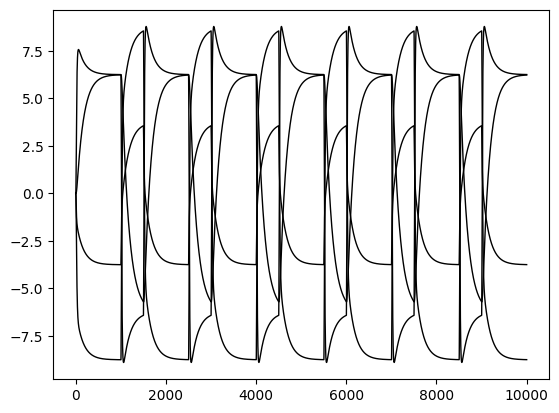

In [2]:
plt.figure()
idx=9
# Last loop (i == 10), plot in black
plt.plot(time, Temps[idx, 0, 1, :], 'k', linewidth=1)
plt.plot(time, Temps[idx, 0, 2, :], 'k', linewidth=1)
plt.plot(time, Temps[idx, 0, 3, :], 'k', linewidth=1)
plt.plot(time, Temps[idx, 0, 4, :], 'k', linewidth=1)

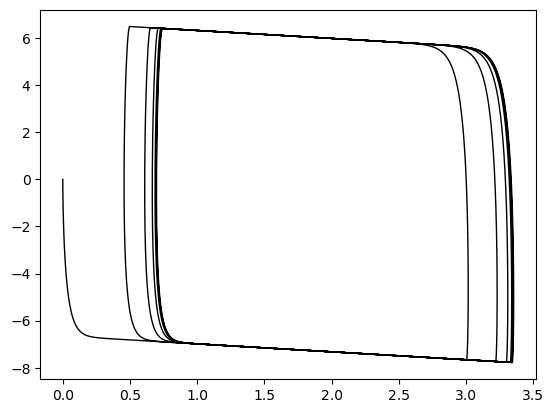

In [7]:
plt.figure()
idx=9

plt.plot(Temps[idx, 0, 1, :], Temps[idx, 0, 4, :], 'k', linewidth=1)


In [3]:
Temps[idx, 0, 1:5, :].shape

(4, 10000)

# PCMCI using orginal data

(<Figure size 640x480 with 4 Axes>,
 array([<Axes: ylabel='Box 1'>, <Axes: ylabel='Box 2'>,
        <Axes: ylabel='Box 3'>, <Axes: ylabel='Box 4'>], dtype=object))

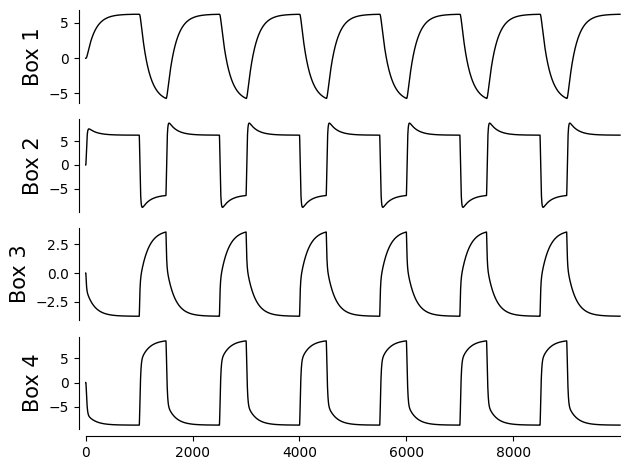

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn
import pandas as pd

idx = 9  # Index of the last simulation without noise
# Convert the dictionary to an array suitable for Tigramite's DataFrame
data_array = Temps[idx, 0, 1:5, :].T


# # For data_array, for the first column, replace it with its derivative
# first_col_diff = np.diff(data_array[:, 0])
# # drop the last row of data_array
# data_array = data_array[:-1, :]
# # replace the first column with the derivative
# data_array[:, 0] = first_col_diff


# Create a Tigramite DataFrame object
var_names = [f"Box {k+1}" for k in range(4)]

# create adataframe called 'df4stationary_check' with the data_array and the variable names
df4stationary_check= pd.DataFrame(data_array, columns=var_names)

dataframe_TEMP = pp.DataFrame(data_array, datatime=np.arange(data_array.shape[0]), var_names=var_names)
tp.plot_timeseries(dataframe_TEMP,label_fontsize=15,tick_label_size=10)

In [11]:
df4stationary_check

,Box 1,Box 2,Box 3,Box 4
0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.100000,-0.050000,-0.050000
4,0.000050,0.274950,-0.130000,-0.145000
...,...,...,...,...
9995,3.332825,7.209932,-2.776998,-7.770330
9996,3.334775,7.209290,-2.777649,-7.770985
9997,3.336724,7.208648,-2.778299,-7.771640
9998,3.338671,7.208006,-2.778949,-7.772295


In [15]:
from toolbox import GC_functions as GC  # Assuming GC_functions is your custom module


df4stationary_check = GC.make_stationary(df4stationary_check,['Box 1', 'Box 2', 'Box 3','Box 4'], test_method='ADF', plot=True,print_results=True)
# df4stationary_check

ADF Statistic: -6.008700771023675
p-value: 1.5925045778792947e-07
Critical Values:
	1%: -3.4310043597505673
	5%: -2.8618291880722437
	10%: -2.5669239296731097
The series is stationary.
Series in column 'Box 1' is stationary after 0 differencing operation(s).
ADF Statistic: -4.080766502469107
p-value: 0.0010419038786052292
Critical Values:
	1%: -3.431004294278137
	5%: -2.861829159140512
	10%: -2.5669239142727114
The series is stationary.
Series in column 'Box 2' is stationary after 0 differencing operation(s).
ADF Statistic: -3.7734646193298595
p-value: 0.003190778352737592
Critical Values:
	1%: -3.431004294278137
	5%: -2.861829159140512
	10%: -2.5669239142727114
The series is stationary.
Series in column 'Box 3' is stationary after 0 differencing operation(s).
ADF Statistic: -3.7760542188161303
p-value: 0.003162036249246079
Critical Values:
	1%: -3.4310044907347454
	5%: -2.8618292459530794
	10%: -2.566923960483154
The series is stationary.
Series in column 'Box 4' is stationary after 0

# Partial correlation


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 199
tau_max = 201
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable Box 1 has 4 link(s):
    [pc_alpha = 0.5]
        (Box 2 -200): max_pval = 0.28414, |min_val| =  0.011
        (Box 3 -199): max_pval = 0.31480, |min_val| =  0.010
        (Box 4 -201): max_pval = 0.45909, |min_val| =  0.008
        (Box 1 -199): max_pval = 0.49826, |min_val| =  0.007

    Variable Box 2 has 0 link(s):
    [pc_alpha = 0.05]

    Variable Box 3 has 6 link(s):
    [pc_alpha = 0.05]
        (Box 1 -201): max_pval = 0.00000, |min_val| =  0.077
        (Box 3 -201): max_pval = 0.00000, |min_val| =  0.077
        (Box 4 -201): max_pval = 0.00000, |min_val| =  0.074
        (Box 3 -199): max_pval = 0.00000, |min_val| =  0.070
        (Box 2 -199): max_pval = 0.00023, |min_val| =  0.038
        (Box 3 -200

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

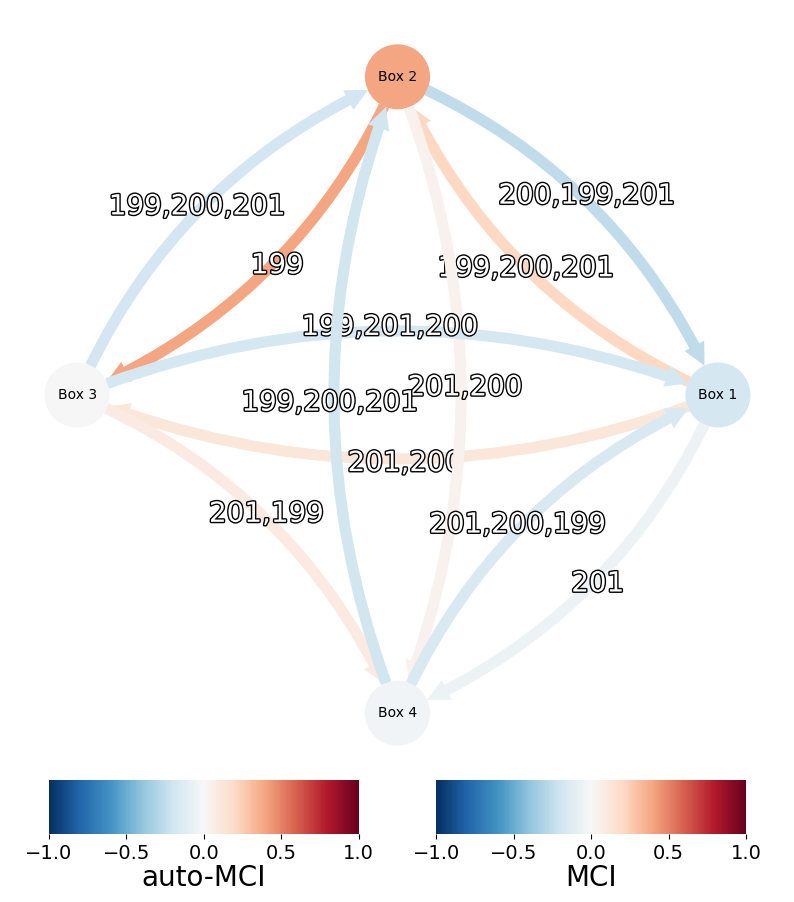

In [9]:
ParCorr = parcorr.ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe_TEMP,
    cond_ind_test=ParCorr,
    verbosity=1)

pcmci.verbosity = 1
tau_max=201
results = pcmci.run_pcmci(tau_min=199, tau_max=tau_max, pc_alpha=None)
# q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
tp.plot_graph(
    fig_ax=(fig, ax),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=10,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.2
    )

# Gaussian process regression and a distance correlation (GPDC)

In [11]:
from tigramite.independence_tests import gpdc

gpdc_test = gpdc.GPDC(significance='analytic', gp_params=None)
pcmci_gpdc = PCMCI(
    dataframe=dataframe_TEMP, 
    cond_ind_test=gpdc_test,
    verbosity=0)

pcmci.verbosity = 1
tau_max=2

results = pcmci_gpdc.run_pcmci(tau_max=tau_max, pc_alpha=None, alpha_level = 0.01)
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    show_colorbar=False,
    )

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(20, 20), dpi=100)
tp.plot_graph(
    fig_ax=(fig, ax),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=10,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.2
    )

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_ve

KeyboardInterrupt: 

# Conditional mutual information

In [4]:
cmi_knn = cmiknn.CMIknn(significance='shuffle_test', knn=0.5, shuffle_neighbors=2, transform='ranks', sig_samples=10)

pcmci = PCMCI(
    dataframe=dataframe_TEMP,
    cond_ind_test=cmi_knn,
    verbosity=1)

pcmci.verbosity = 1
tau_max=2
results = pcmci.run_pcmci(tau_min=1, tau_max=tau_max, pc_alpha=None)
# q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(20, 20), dpi=100)
tp.plot_graph(
    fig_ax=(fig, ax),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=10,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.2
    )


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = cmi_knn
tau_min = 1
tau_max = 2
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1




: 

# PCMCI using differenciated data

(<Figure size 640x480 with 4 Axes>,
 array([<Axes: ylabel='Box 1'>, <Axes: ylabel='Box 2'>,
        <Axes: ylabel='Box 3'>, <Axes: ylabel='Box 4'>], dtype=object))

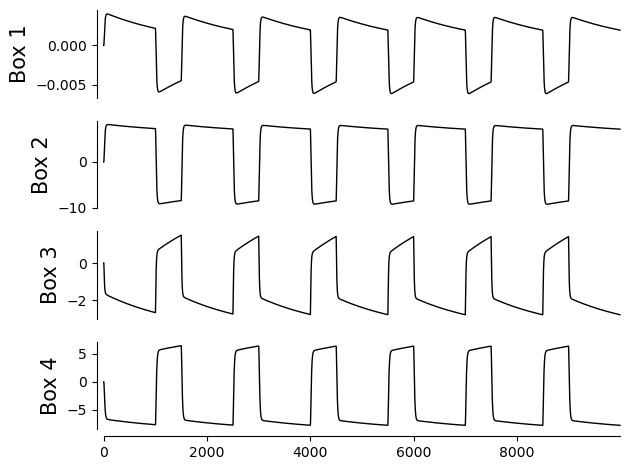

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn
import pandas as pd

idx = 9  # Index of the last simulation without noise
# Convert the dictionary to an array suitable for Tigramite's DataFrame
data_array = Temps[idx, 0, 1:5, :].T.copy()

# For data_array, for the first column, replace it with its derivative
first_col_diff = np.diff(data_array[:, 0])
# drop the last row of data_array
data_array = data_array[:-1, :]
# replace the first column with the derivative
data_array[:, 0] = first_col_diff


# Create a Tigramite DataFrame object
var_names = [f"Box {k+1}" for k in range(4)]

# create adataframe called 'df4stationary_check' with the data_array and the variable names
df4stationary_check= pd.DataFrame(data_array, columns=var_names)

dataframe_TEMP = pp.DataFrame(data_array, datatime=np.arange(data_array.shape[0]), var_names=var_names)
tp.plot_timeseries(dataframe_TEMP,label_fontsize=15,tick_label_size=10)

In [24]:
data_array.shape

(10000, 4)

In [13]:
from toolbox import GC_functions as GC  # Assuming GC_functions is your custom module


df4stationary_check = GC.make_stationary(df4stationary_check,['Box 1', 'Box 2', 'Box 3','Box 4'], test_method='ADF', plot=True,print_results=True)
# df4stationary_check

ADF Statistic: -4.055126035626699
p-value: 0.0011478298185430133
Critical Values:
	1%: -3.4310056719563438
	5%: -2.861829767925114
	10%: -2.566924238329569
The series is stationary.
Series in column 'Box 1' is stationary after 0 differencing operation(s).
ADF Statistic: -4.081770372417985
p-value: 0.0010379487579867692
Critical Values:
	1%: -3.4310043597505673
	5%: -2.8618291880722437
	10%: -2.5669239296731097
The series is stationary.
Series in column 'Box 2' is stationary after 0 differencing operation(s).
ADF Statistic: -3.7754908776610723
p-value: 0.0031682684765280827
Critical Values:
	1%: -3.4310043597505673
	5%: -2.8618291880722437
	10%: -2.5669239296731097
The series is stationary.
Series in column 'Box 3' is stationary after 0 differencing operation(s).
ADF Statistic: -3.7770260768132955
p-value: 0.0031513110897006553
Critical Values:
	1%: -3.431004556246501
	5%: -2.8618292749021865
	10%: -2.5669239758928017
The series is stationary.
Series in column 'Box 4' is stationary afte


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable Box 1 has 0 link(s):
    [pc_alpha = 0.05]

    Variable Box 2 has 1 link(s):
    [pc_alpha = 0.05]
        (Box 2 -1): max_pval = 0.00000, |min_val| =  0.066

    Variable Box 3 has 0 link(s):
    [pc_alpha = 0.05]

    Variable Box 4 has 3 link(s):
    [pc_alpha = 0.3]
        (Box 2 -1): max_pval = 0.00832, |min_val| =  0.026
        (Box 1 -2): max_pval = 0.07670, |min_val| =  0.018
        (Box 1 -1): max_pval = 0.27948, |min_val| =  0.011

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 1
tau_max = 2
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.05:

    Variable Box 1 has 8 link(s):
        (Box 1 -1): pval = 0.00000 | val =  1.000
        (Box 1 -

(<Figure size 2000x2000 with 1 Axes>, <Axes: >)

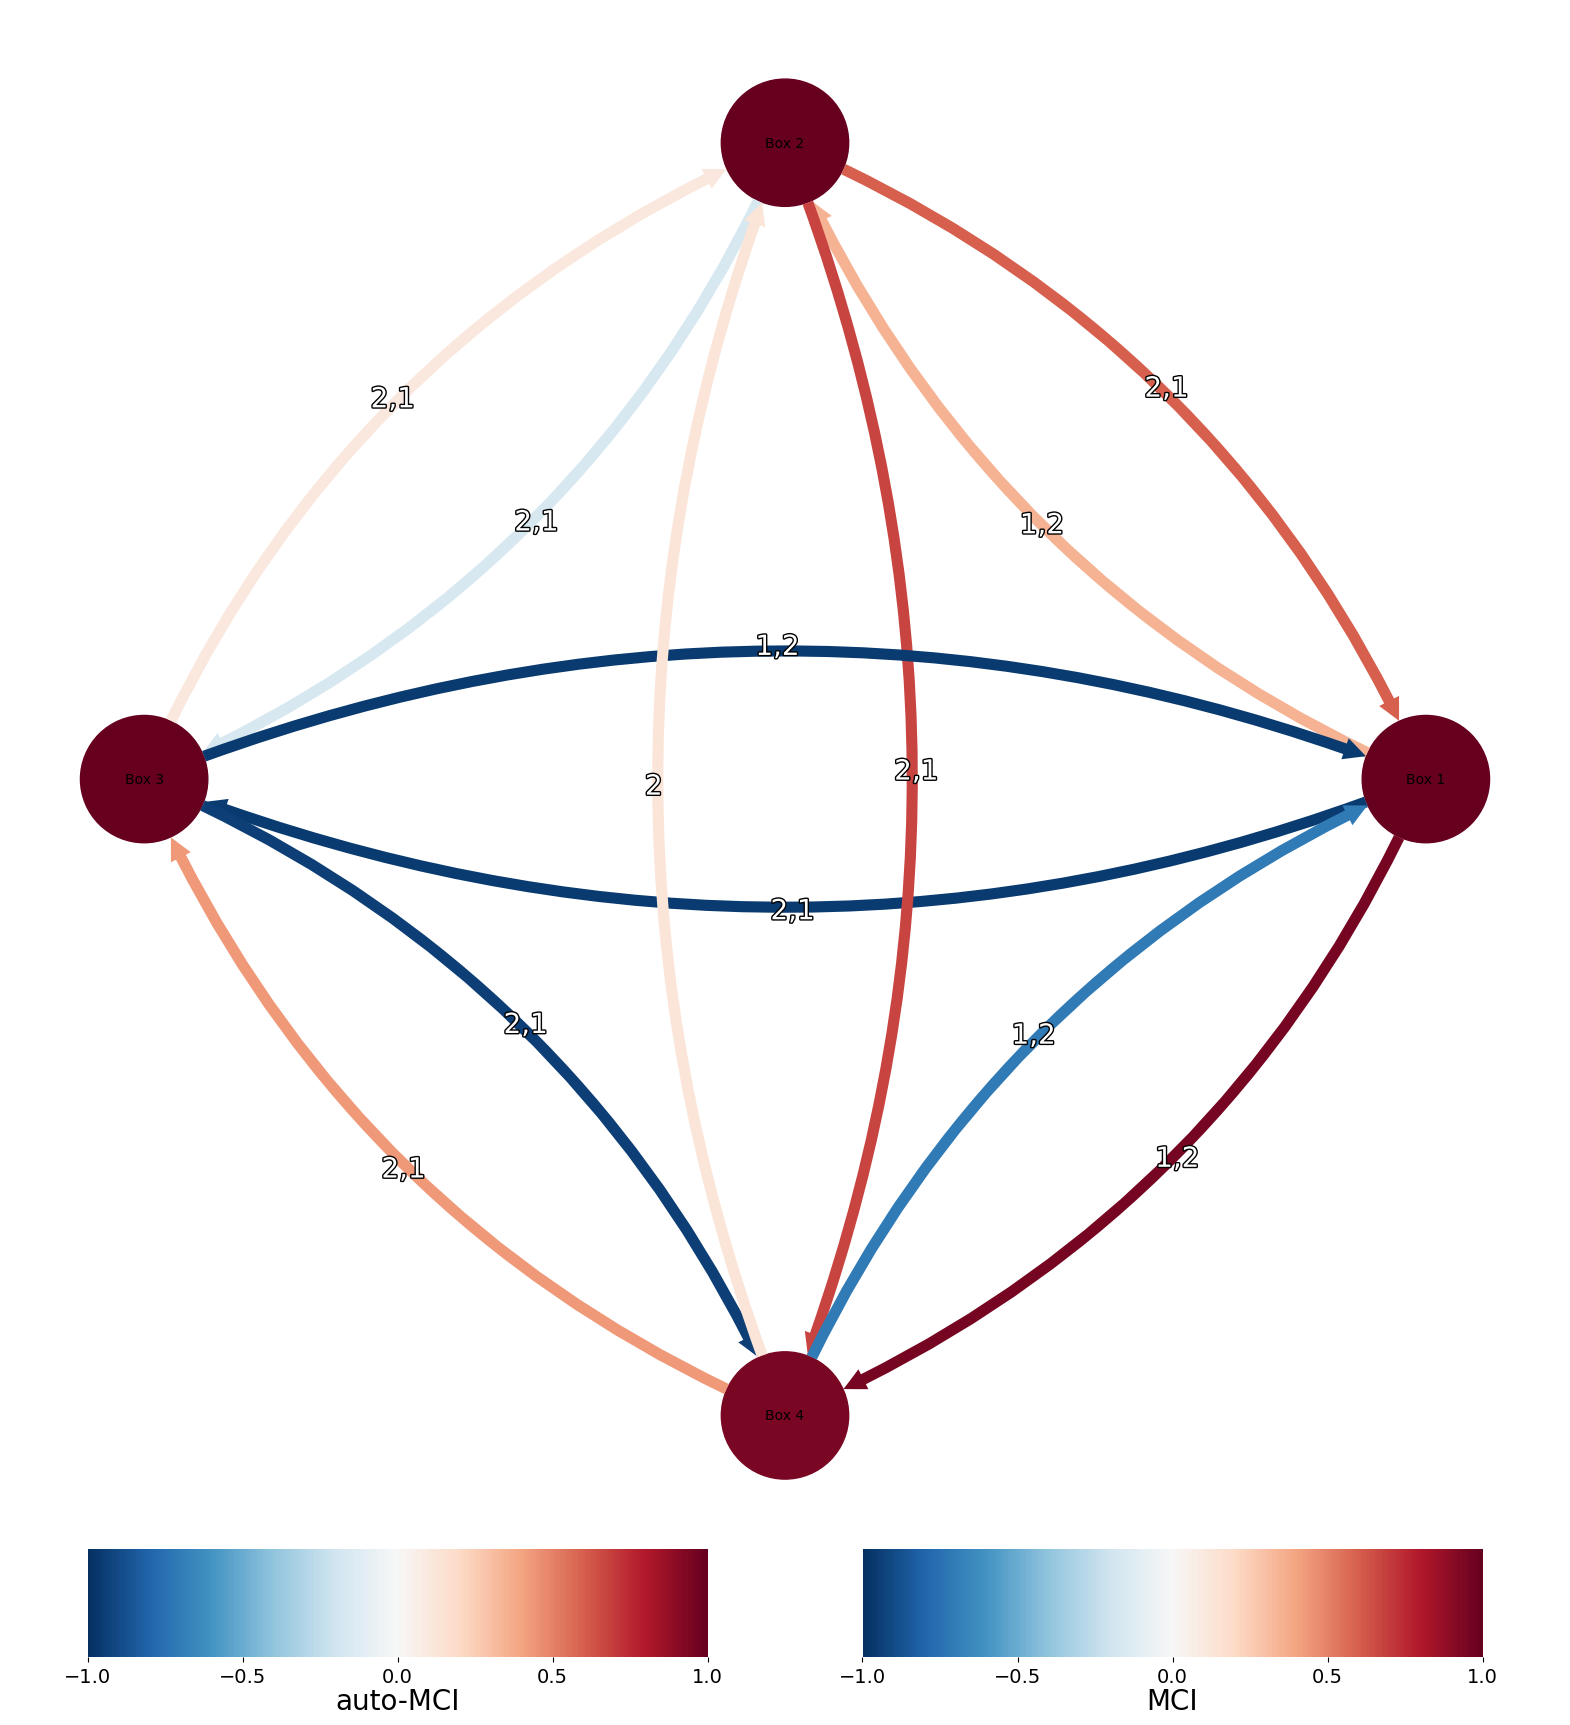

In [26]:
ParCorr = parcorr.ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe_TEMP,
    cond_ind_test=ParCorr,
    verbosity=1)

pcmci.verbosity = 1
tau_max=2
results = pcmci.run_pcmci(tau_min=1, tau_max=tau_max, pc_alpha=None)
# q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(20, 20), dpi=100)
tp.plot_graph(
    fig_ax=(fig, ax),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=10,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.2
    )

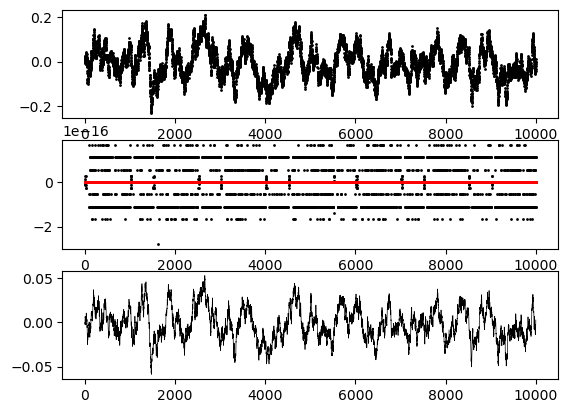

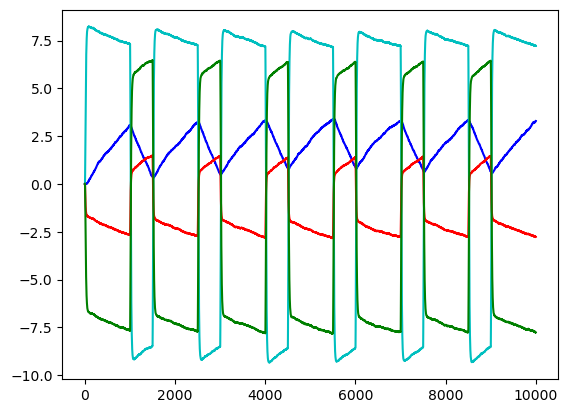

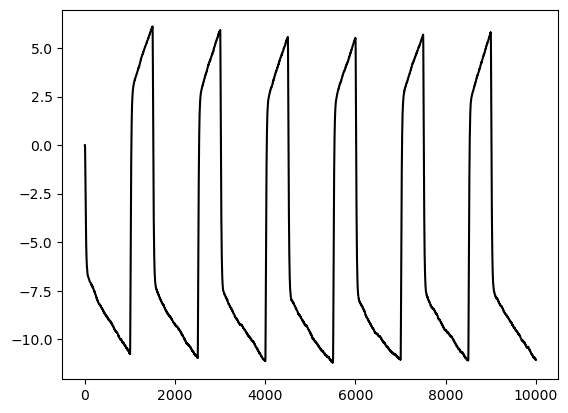

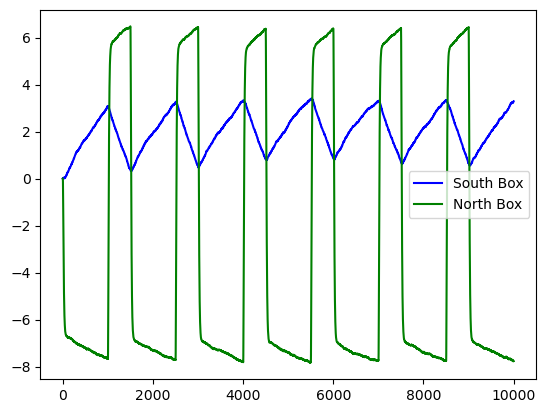

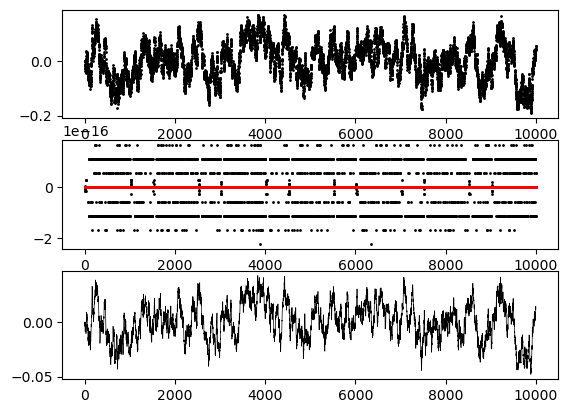

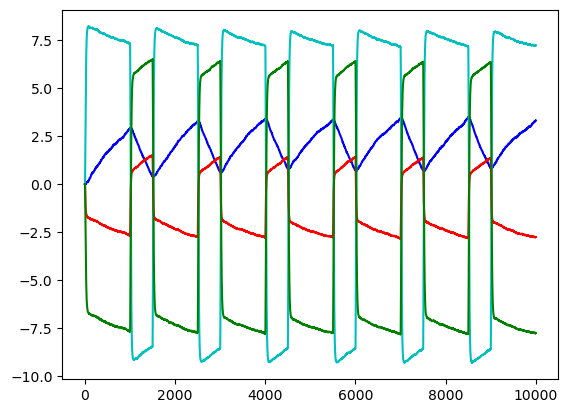

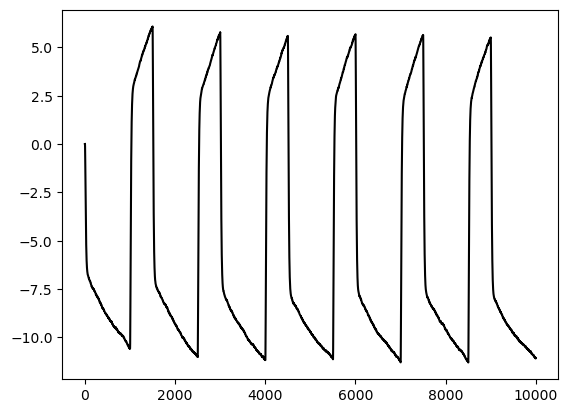

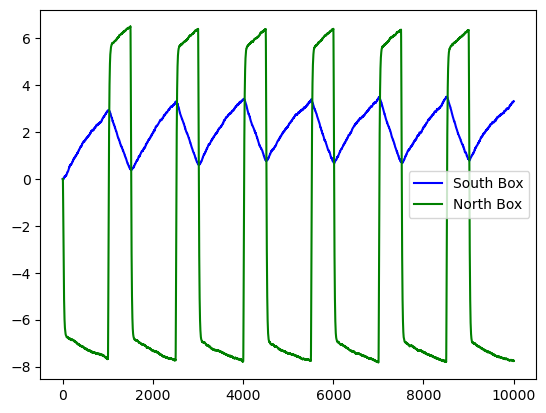

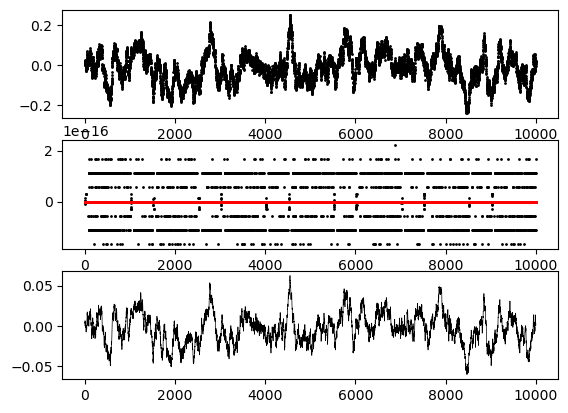

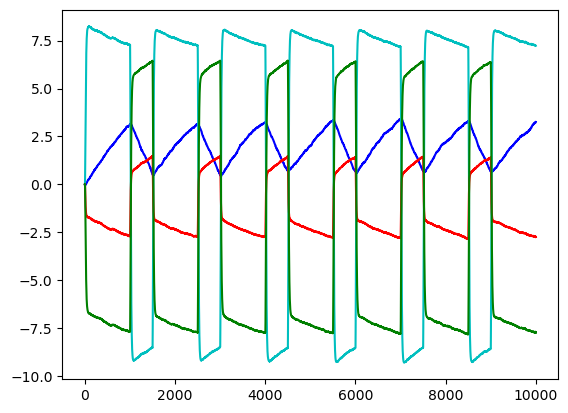

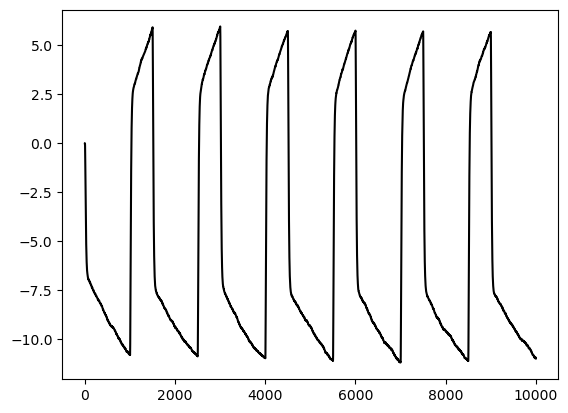

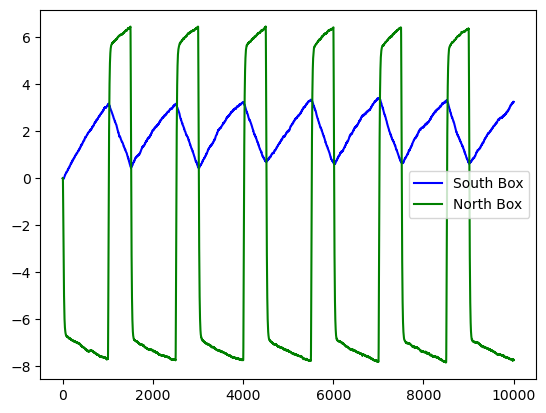

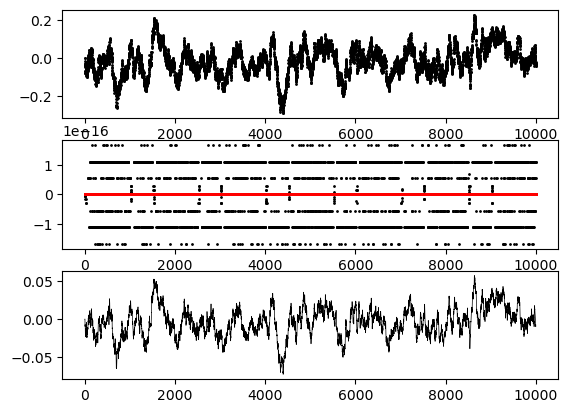

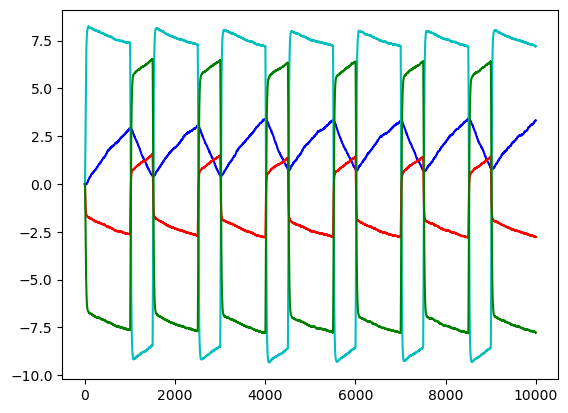

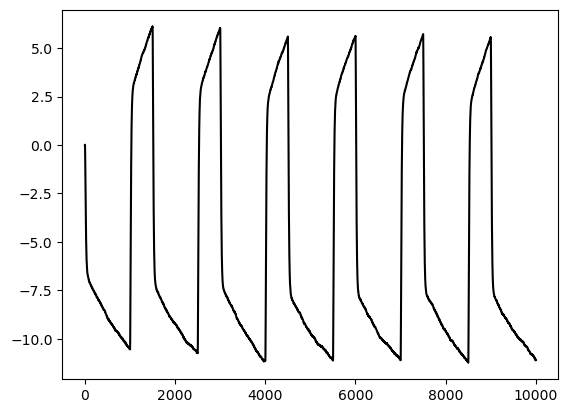

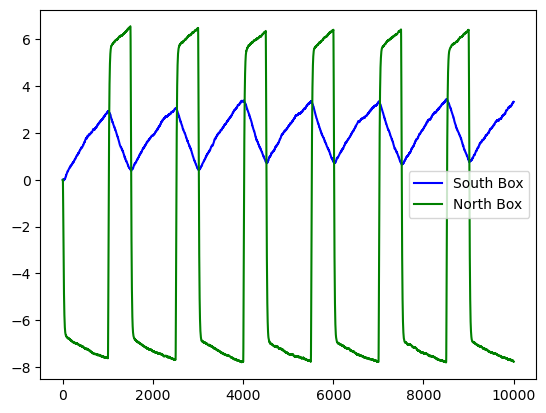

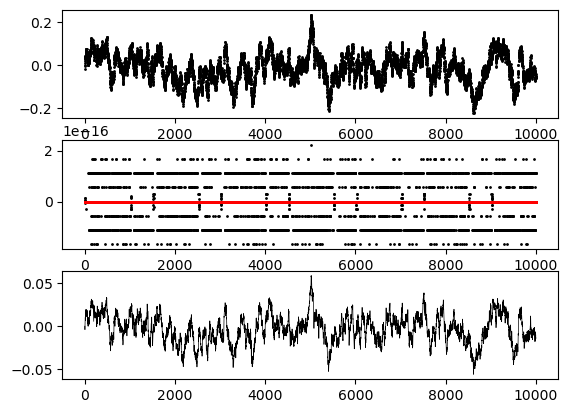

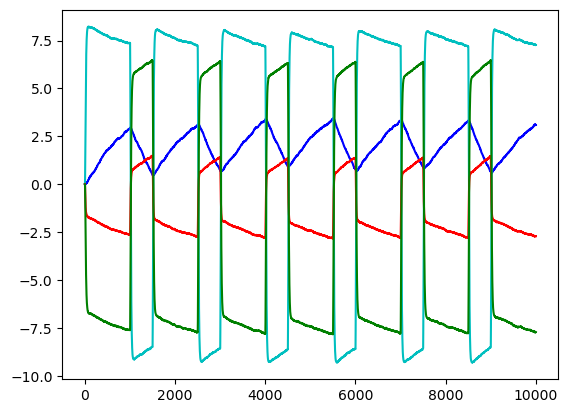

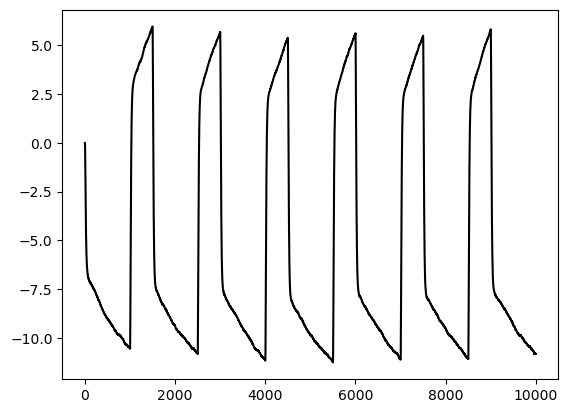

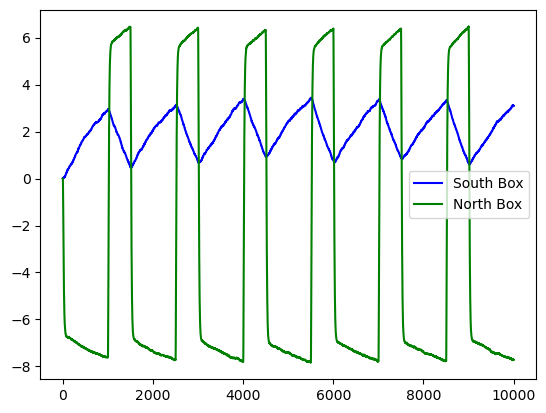

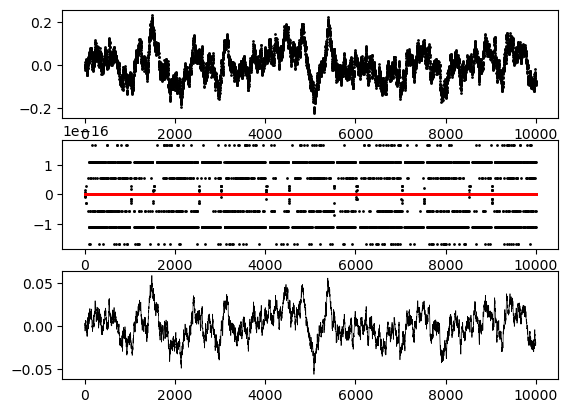

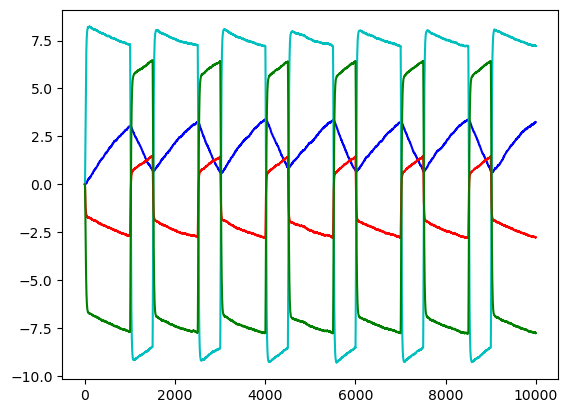

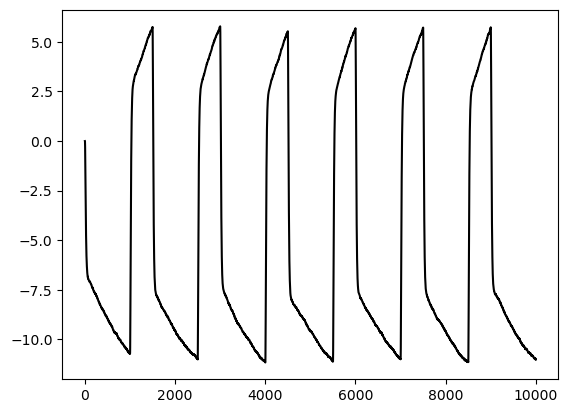

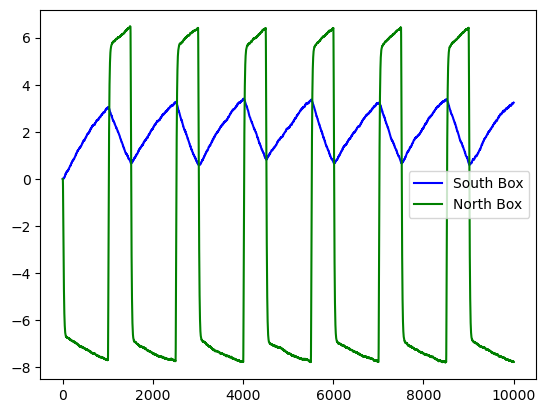

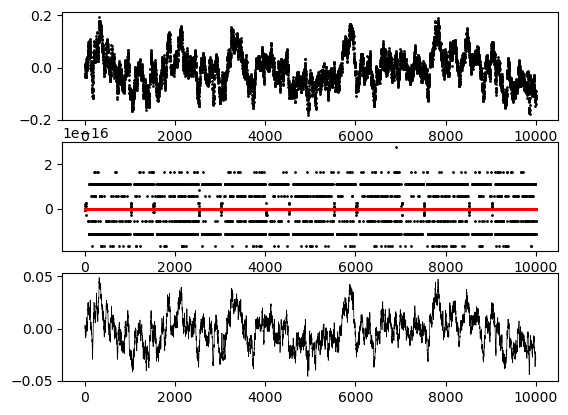

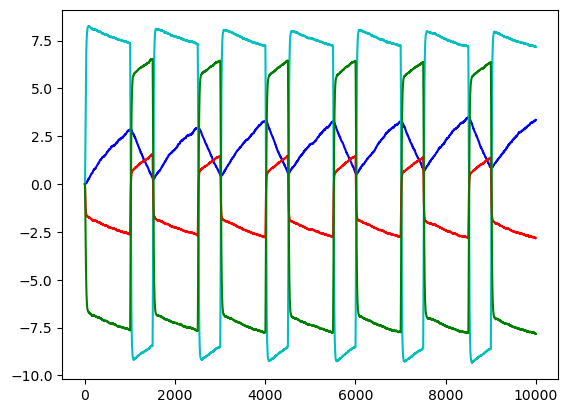

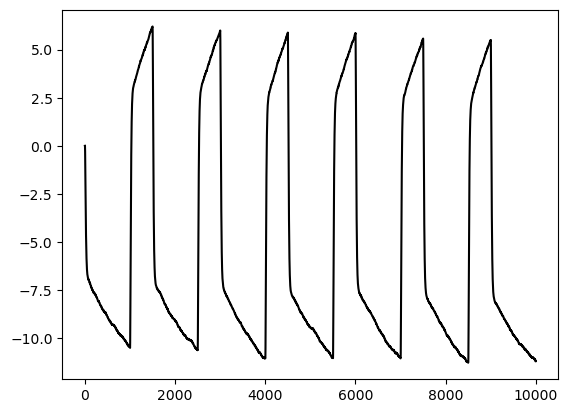

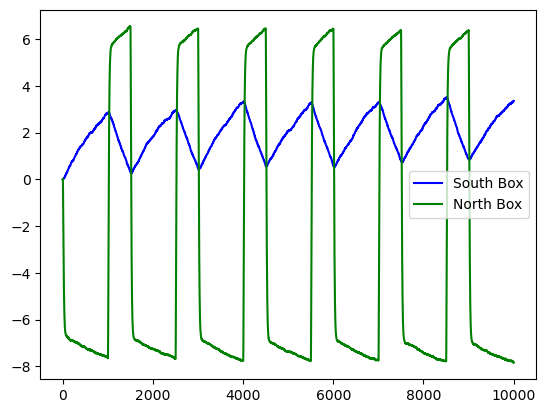

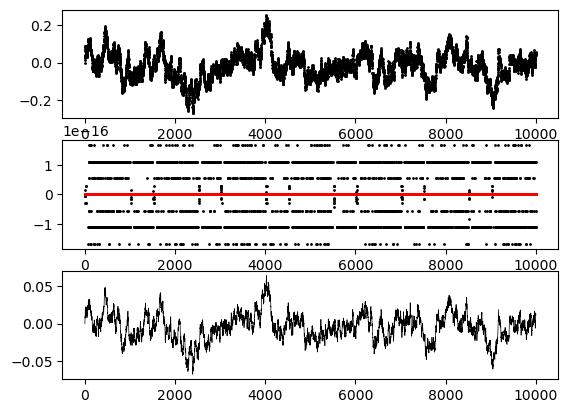

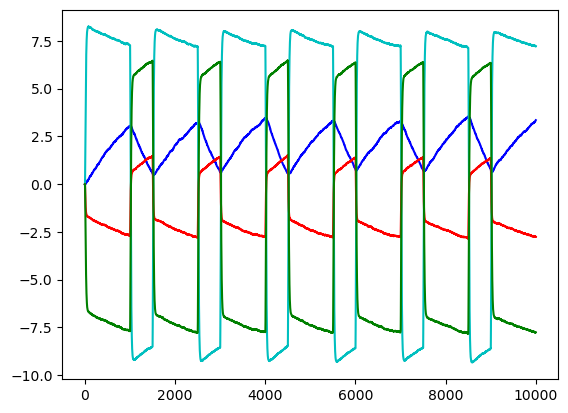

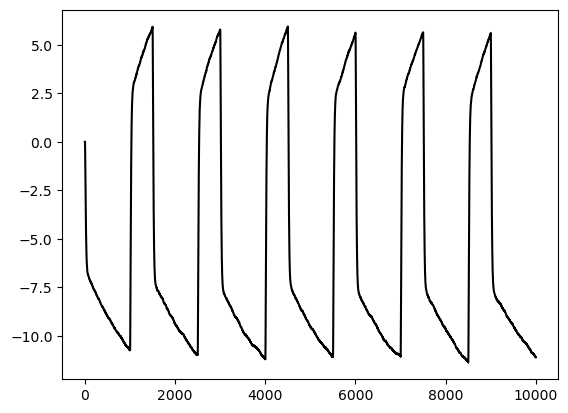

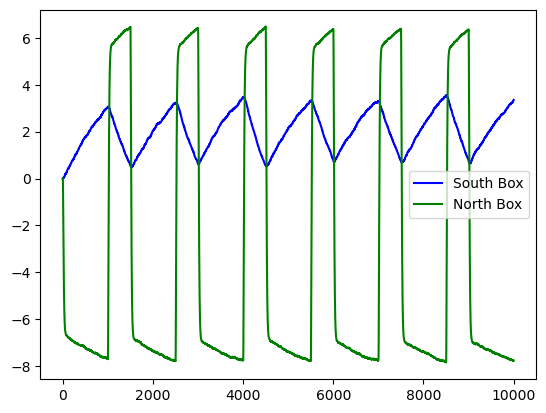

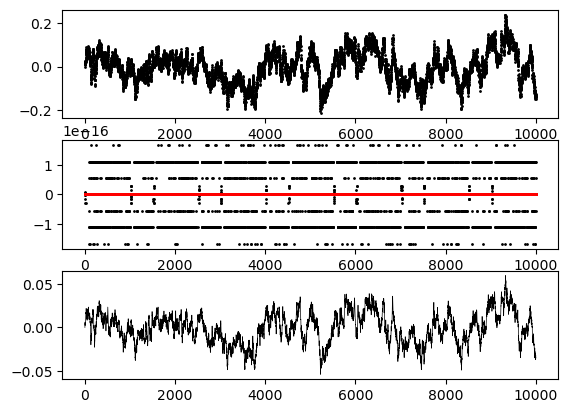

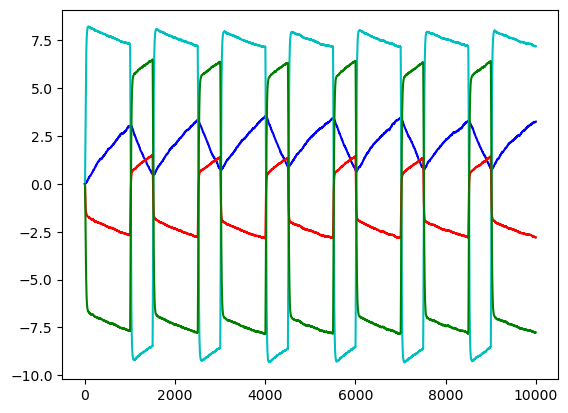

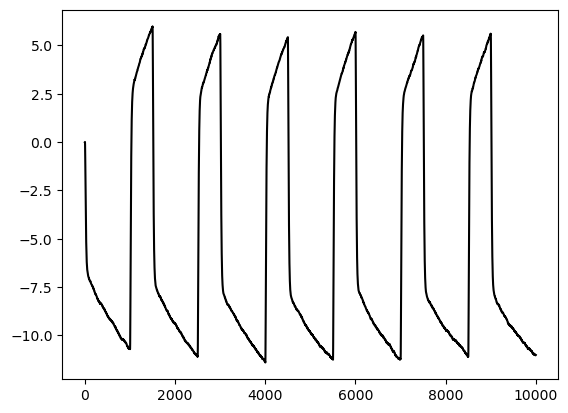

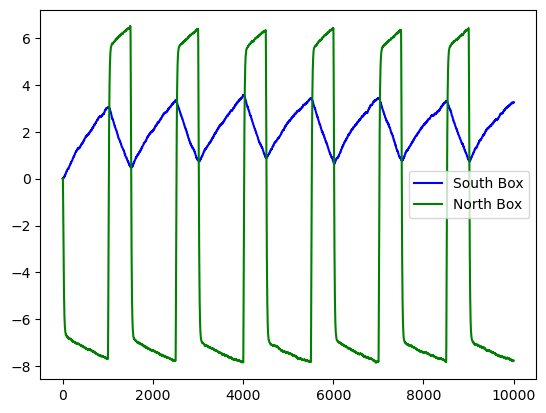

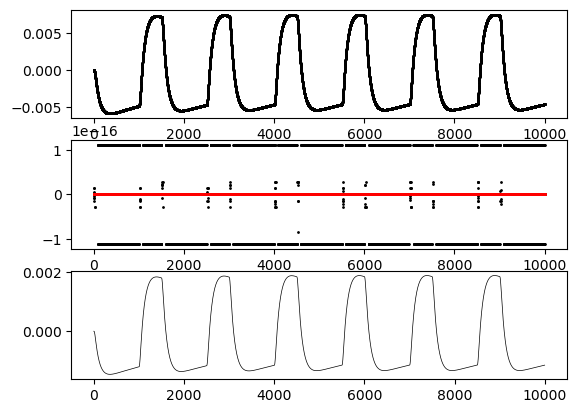

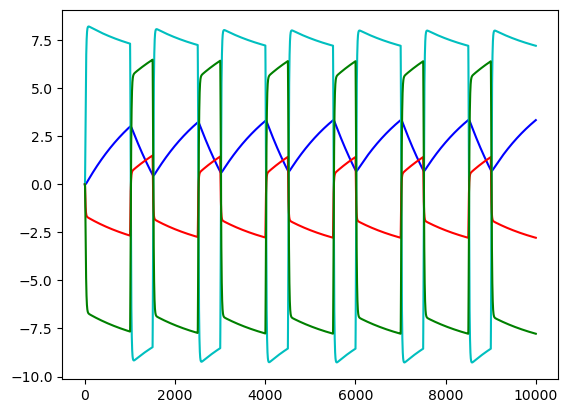

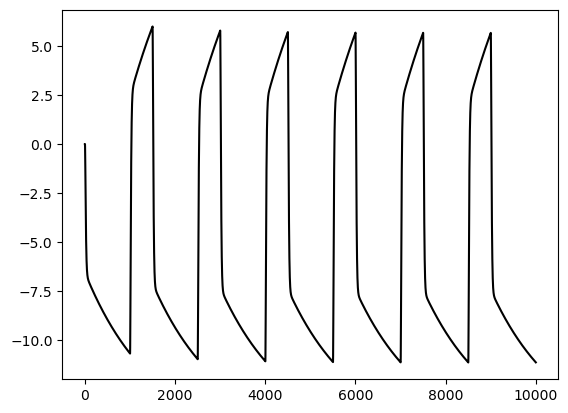

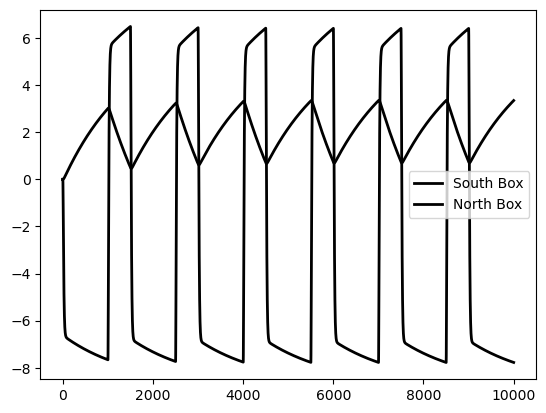

In [50]:
# ----------------------------------------------------------------------- #
#   Very rough draft of 1D diffusion/advection model for testing          #
#   Date: 14/10/2024            
#   Adapted from 2D diffusion/advection to there are some vestigial
#   features
#   Author: Thomas Bauska <thausk@bas.ac.uk>                              #
#                                                                         #
#=========================Basic Setup=====================================#
#-------------------------------------------------------------------------#

import numpy as np
import matplotlib.pyplot as plt

nx = 1     # core boxes akin to longitude (don't change!)
ny = 4     # core boxes akin to latitude (don't change!)

#--> NOTE: the boundary condition on the north and south (y) is a Neumann
# so there are a total of 6 boxes with boxes 1 and 6 forced to equal to boxes 
# 2 and 5, respectively. They are like ghost boxes such that derivative at the
# true boundary is zero.

# Boundary conditions on east and west (x) are wrapped around such that the grid is continuous

lengthx = 1  # domain length along x (unitless) (don't change!)
lengthy = 4  # domain length along y (unitless) don't change!)

dt = 1       # time step [nominally yr]  (there are some stability check below)
runlength = 10000  # length in years  <======CAN CHANGE 
nsteps = int(runlength / dt)  # number of timesteps (feel free to change)
bpss_reoccurence = 1000  # recurrence interval in years <======CAN CHANGE 
bpss_length = 500        # length of perturbation in years <======CAN CHANGE 

for i in range(1, 11):  # this is a little loop which runs 9 simulations with noise and the last one without.

    # ===============Switches, Knobs and Tunable Parameters=====================#
    # -------------------------------------------------------------------------#
    # --Diffusion--#
    Dy_var = [0.0005, 0.0005, 0.1, 0.1, 0.1]  # Variable diffusive parameter along y  <======CAN CHANGE 
    # wy = 5  # advective flux (currently defunct)
    maxD = 0.1  # some relict code to check numerical stability. Here you can enter maximum diffusion rate
    maxw = 0.0  # some relict code to check numerical stability. Here you can enter maximum advection rate

    # --Noise--#
    if i == 10:
        wnoise_level = 0
    else:
        wnoise_level = 0.005  # total white noise level <======CAN CHANGE 

    wnoise_sigma = np.array([1, 1, 1, 1, 1, 1]) * wnoise_level  # sets level of white noise in each latitude 
    wnoise_dt = 1  # sets timestep for noise (ie. if dt = 1 an annual noise timeseries is interpolated to the model grid)

    # --Response times--#
    arb_bpss_target = 0   # this sets the magnitude of the bipolar seesaw heat flux.
    arb_bpss_tau = 10     # this sets the rate (nominally years) that the model moves towards the full bipolar seesaw heat flux.

    rectifier_global_temp = 0      # this forces the global average temperature to tend to the set value
    rectifier_global_tau = 100     # this sets the rate (nominally years) that the model tends back to the set values. If you want to turn off the effect, set it to a very large number.

    rectifier_area_temp = 0        # this forces a set of grid cells in the model to to the set value.  
    rectifier_area_tau = 100000    # this sets the rate (nominally years) that the model tends back to the set values. If you want to turn off the effect, set it to a very large number.

    gain = [0, 0, 0, 0, 0, 0]      # this currently doesn't work..

    timetrip_pre = np.arange(1, 21)

    timetrip = np.column_stack((
        bpss_reoccurence * timetrip_pre + bpss_length * (timetrip_pre - 1),
        (bpss_reoccurence + bpss_length) * timetrip_pre
    ))

    # ============Pre-processing of user-defined data==========================#
    # -------------------------------------------------------------------------#
    # Calculate grid steps
    hx = lengthx / nx      # grid step along x (unitless) 
    hy = lengthy / ny      # grid step along y (unitless) 

    # Numerical setup: time step (stability conditions)
    sigma = 0.7                       # safety coefficient
    dt_diff = (1 / 4) * min(hx ** 2, hy ** 2) / maxD   # diffusion [yr]
    if maxw == 0:
        dt_conv = np.inf
    else:
        dt_conv = 4 * maxD / (maxw ** 2)  # convection [yr]
    dtstabilitycheck = sigma * min(dt_diff, dt_conv)   # time step [yr]

    if dt > dtstabilitycheck:
        print('might be numerically unstable')
        print(dt / dtstabilitycheck)
    else:
        pass

    # Calculate time steps
    time = np.arange(1, nsteps + 1) * dt

    # Memory allocation
    Temp = np.zeros((nx, ny + 2, nsteps))     # Temperature
    arb_bpss_target_time = np.zeros(nsteps)   # the target value for the bipolar seesaw heat flux parameter. The actual value tends to this in a lagged response.
    arb_bpss_actual_time = np.zeros(nsteps)   # the actual value for the bipolar seesaw heat flux parameter.
    Fadv = np.zeros((nx, ny + 2, nsteps))     # Advective Flux 
    F = np.zeros((nx, ny + 2, nsteps))        # Diffusive Flux
    Fgain = np.zeros((nx, ny + 2, nsteps))    # Gain Flux (not active!)
    Frectifier_global = np.zeros((nx, ny + 2, nsteps))  # Rectifier Flux when using the global mean temperature
    Frectifier_area = np.zeros((nx, ny + 2, nsteps))      # Rectifier Flux when using the just a set area
    wnoiseint = np.zeros((nx, ny + 2, nsteps))           # white noise

    # White noise production
    wnoiserawtime = np.arange(0, time[-1] + wnoise_dt, wnoise_dt)
    wnoiseraw_shape = (nx, ny + 2, len(wnoiserawtime))
    wnoiseraw = wnoise_sigma.reshape(1, -1, 1) * np.random.randn(*wnoiseraw_shape)

    # Interpolate white noise to time grid
    for y in range(ny + 2):
        for x in range(nx):
            wnoiseint[x, y, :] = np.interp(time, wnoiserawtime, wnoiseraw[x, y, :])

    # Initialize arrays for global and area temperature
    global_temp_arr = np.zeros(nsteps)
    area_temp_arr = np.zeros(nsteps)

    # ============================Core Equations===============================#
    # -------------------------------------------------------------------------#
    for t in range(nsteps - 1):
        for y in range(1, 5):
            x = 0
            F[x, y, t + 1] = +(Dy_var[y] * dt / hy ** 2) * (Temp[x, y + 1, t] - Temp[x, y, t]) \
                            + (Dy_var[y - 1] * dt / hy ** 2) * (Temp[x, y - 1, t] - Temp[x, y, t])
        #
        # -----Special Advection Forcing------#
        x = 0
        y = 4
        arb_bpss_target_time[t] = arb_bpss_target
        arb_bpss_actual_time[t + 1] = arb_bpss_actual_time[t] \
                                      + (arb_bpss_target_time[t] - arb_bpss_actual_time[t]) * dt * (1 / arb_bpss_tau)

        Fadv[x, y - 2, t + 1] = -arb_bpss_actual_time[t] * dt
        Fadv[x, y - 1, t + 1] = +0.5 * arb_bpss_actual_time[t] * dt
        Fadv[x, y, t + 1] = +0.5 * arb_bpss_actual_time[t] * dt

        # -----Summing up, Switches and Feedbacks-----#        
        global_temp_arr[t] = Temp[0, 1:5, t].mean()
        area_temp_arr[t] = Temp[0, 2:4, t].mean()
        Frectifier_global[:, :, t + 1] = (rectifier_global_temp - global_temp_arr[t]) * (1 / rectifier_global_tau) * dt

        Frectifier_area[x, 2:4, t + 1] = (rectifier_area_temp - area_temp_arr[t]) * (1 / rectifier_area_tau) * dt
        Temp[:, :, t + 1] = Temp[:, :, t] \
                           + F[:, :, t + 1] \
                           + Fadv[:, :, t + 1] \
                           + wnoiseint[:, :, t + 1] \
                           + Frectifier_global[:, :, t + 1] \
                           + Frectifier_area[:, :, t + 1] \
                           + Fgain[:, :, t]
        Fgain[:, :, t + 1] = np.array(gain).reshape(1, -1) * (Temp[:, :, t + 1] - Temp[:, :, t])

        # ----Finding the right time to turn off and on----#   
        if any((time[t] > timetrip[k, 0]) and (time[t] < timetrip[k, 1]) for k in range(20)):
            arb_bpss_target = 1   # this in ON trip <======CAN CHANGE 
        else:
            arb_bpss_target = -1  # this in OFF trip <======CAN CHANGE 

        # North and South Boundary conditions (Neumann's)
        Temp[0, 0, t + 1] = Temp[0, 1, t + 1]
        Temp[0, 5, t + 1] = Temp[0, 4, t + 1]

    # =============================Figures=====================================#
    # -------------------------------------------------------------------------#
    plt.figure(1)
    plt.subplot(3, 1, 1)
    plt.plot(time, np.squeeze(np.sum(Temp[:, 1:5, :], axis=(0, 1))), 'ko',markersize=1)
    plt.subplot(3, 1, 2)
    plt.plot(time, np.squeeze(np.sum(F[:, 1:5, :], axis=(0, 1))), 'ko',markersize=1)
    plt.plot(time, np.squeeze(np.sum(Fadv[:, 1:5, :], axis=(0, 1))), 'ro',markersize=1)
    plt.subplot(3, 1, 3)
    plt.plot(time[:-1], global_temp_arr[:-1], 'k',linewidth=0.5)

    plt.figure(2)
    plt.plot(time, np.squeeze(Temp[0, 1, :]), 'b')
    plt.plot(time, np.squeeze(Temp[0, 2, :]), 'c')
    plt.plot(time, np.squeeze(Temp[0, 3, :]), 'r')
    plt.plot(time, np.squeeze(Temp[0, 4, :]), 'g')

    plt.figure(3)
    plt.plot(time, np.squeeze(Temp[0, 4, :]) - np.squeeze(Temp[0, 1, :]), 'k')

    plt.figure(6)
    if i == 10:
        plt.plot(time, np.squeeze(Temp[0, 1, :]), 'k', linewidth=2)
        plt.plot(time, np.squeeze(Temp[0, 4, :]), 'k', linewidth=2)
        plt.legend(['South Box', 'North Box'])
    else:
        plt.plot(time, np.squeeze(Temp[0, 1, :]), 'b')
        plt.plot(time, np.squeeze(Temp[0, 4, :]), 'g')
        plt.legend(['South Box', 'North Box'])
    plt.show()


In [48]:
Temp.shape

(1, 6, 10000)

In [49]:
np.squeeze(Temp[0, 4, :]).shape

(10000,)